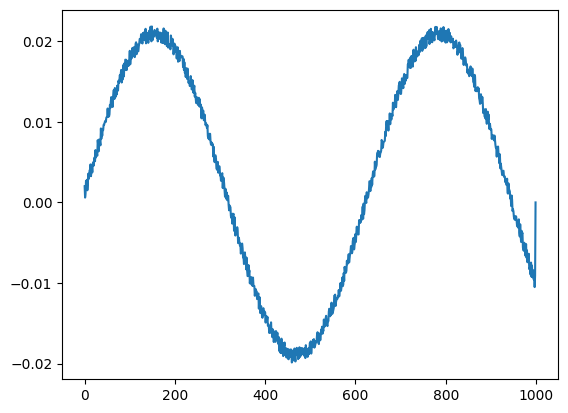

In [26]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

# First define the problem
N = 1000
x = np.linspace(0, 1., N)

A = np.diag(np.ones(N - 1), 1) + np.diag(np.ones(N - 1), -1)*(-1)
A = scipy.sparse.csr_matrix(A)
A
b = np.zeros(N)
for i in range(N-1):
    b[i] = np.sin((i+1)*.01)*0.02 + np.random.random()*0.002
b
plt.plot(b)

In [33]:
# 定义雅可比迭代函数
def jacobi_iteration_sparse(A, b, x0, max_iterations=100, tolerance=1e-6):
    n = len(b)
    x = x0.copy()  # 初始解向量
    x_new = np.zeros_like(x)  # 存储更新后的解向量
    L = scipy.sparse.tril(A, k=-1)
    U = scipy.sparse.triu(A, k=1)
    D = A.diagonal()
    D_inv = 1.0 / D[:]
    D_inv = scipy.sparse.diags(D_inv)
    for iteration in range(max_iterations):
        x_new = D_inv @ (b - (L + U) @ x)

        residual = b - (A @ x_new)
        r_norm = np.linalg.norm(residual)
        if r_norm < tolerance:
            break
        print(f"jacobian iter: {iteration}, residual: {r_norm}")
        x = x_new.copy()
    return x_new, residual


# Then define the multigrid
def amg_step(A1,b1,R,P):
    # pre-smooth jacobian:
    print(f"before jacobian pre-smooth: ")
    print(f"b1:{np.linalg.norm(b1)}")
    x1, r1 = jacobi_iteration_sparse(A1, b1, b1, 3)

    # restriction: pass r1 to r2 and construct A2
    r2 = R @ r1
    A2 = R @ A1 @ P

    # solve coarse level A2E2=r2
    E2 = scipy.sparse.linalg.spsolve(A2, r2)

    # prolongation:
    E1 = P @ E2
    x1 += E1

    r1_new = b1 - A1 @ x1
    # post-smooth jacobian:
    print(f"before jacobian post-smooth: ")
    print(f"new r1:{np.linalg.norm(r1_new)}")
    x1, r1_new = jacobi_iteration_sparse(A1, b1, x1, 3)

    r1_new = b1 - A1 @ x1
    print(f"b1:{np.linalg.norm(b1)}, r1: {np.linalg.norm(r1)}, r1_new: {np.linalg.norm(r1_new)}")


In [34]:
P = scipy.sparse.random(N, N, density=0.01)
R = P.T
amg_step(A, b, R, P)

before jacobian pre-smooth: 
b1:0.4450432691296862
jacobian iter: 0, residual: nan
jacobian iter: 1, residual: nan
jacobian iter: 2, residual: nan


C:\Users\GRBJ200045\AppData\Local\Temp\ipykernel_5028\321654830.py:9: RuntimeWarning: divide by zero encountered in divide
  D_inv = 1.0 / D[:]


before jacobian post-smooth: 
new r1:nan
jacobian iter: 0, residual: nan
jacobian iter: 1, residual: nan
jacobian iter: 2, residual: nan
b1:0.4450432691296862, r1: nan, r1_new: nan


c:\Users\GRBJ200045\.conda\envs\ti-release\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:276: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
